**NOTES:**

- Cut off recipes with > 10 ingredients.
- pretrain word embeddings
- use pretrained vectors for classification

**TODOs:**

- Ingredients clean up
- Mismatch between no of unique productname vs. no of unique ingredients
- Subsampling (maybe): it may help to remove some highly common ingredients like salt, sugar, pepper, etc.
- ELMO: context-specific embedding

**Steps:**

- Dataprep: extract central target words and context words
- Dataprep: negative sampling (is it necessary?)
- Dataprep: batch generators
- Training: try different architectures (GlobalAveragePooling1D vs Flatten va SimpleRNN vs multiple SimpleRNN)
- Training: probably bidirectional RNNs are better, since order of words doesn't matter in the recipes.
- Training: use pretrained vectors

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
sys.path.insert(0, '.')
sys.path.insert(0, '..')

In [6]:
import re
import pandas as pd

# Dataprep

## 7-Eleven

In [4]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
recipes.sort_values(by="productname", inplace=True)
recipes.head()

OrderableUPC                                        productname  \
1424   52548514297  00052548514297, 7-Select Mini Powdered Donut, ...   
574    52548500511                                     00052548514419   
254    52548519612  00052548519612, 7-Select Chocolate Cupckae, 4o...   
183    52548565060  00052548565060, 7-Select Go Yum Madeleines 3ct...   
1032   52548603793  00052548603793, 7-Eleven Grape Medley (Green a...   

     category brand                                        ingredients  
1424      NaN   NaN  ENRICHED BLEACHED WHEAT FLOUR (BLEACHED FLOUR,...  
574       NaN   NaN  UNBLEACHED AND BLEACHED ENRICHED FLOUR (WHEAT ...  
254       NaN   NaN  SUGAR, WATER, CORN SYRUP, UNBLEACHED ENRICHED ...  
183       NaN   NaN  UNSALTED BUTTER, SUGAR, UNBLEACHED ENRICHED FL...  
1032      NaN   NaN                           Red Grapes, Green Grapes

In [5]:
labels = list(recipes["productname"].values)
texts = list(recipes["ingredients"].values)

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)
labels

array([  0,   1,   2, ..., 768, 769, 770])

In [7]:
print(f"texts size: {len(texts)}, labels size: {len(labels)}")

texts size: 1397, labels size: 1397


# Food embedding training

## Recipe data (external data)

In [7]:
recipes_aug = pd.read_csv("../data/food_ingredients_augment.csv")
recipes_aug = recipes_aug.loc[recipes_aug["features_value"].notnull(),]
recipes_aug.head()

id                  asins          brand  \
0  AVphBRHOilAPnD_x0OrE             B00HXST15C  Simon Fischer   
1  AVpfNFy1LJeJML434ma2  B008VT0W8C,B0092F8OJ8      McCormick   
2  AVpgT49VLJeJML43MJEz             B00CHTWZ2S     Jolly Time   
3  AVphYgnzLJeJML43aPp2             B002JJYNVW          Ziyad   
4  AVpiS0bOLJeJML43kRsh             B00290W1CY    Fla-Vor-Ice   

                            categories             dateadded  \
0  Grocery & Gourmet Food,Food,Grocery  2017-01-07T20:13:17Z   
1  Grocery & Gourmet Food,Food,Grocery  2016-02-05T21:08:01Z   
2       Grocery & Gourmet Food,Grocery  2014-02-18T01:51:23Z   
3       Grocery & Gourmet Food,grocery  2014-11-04T11:39:27Z   
4       Grocery & Gourmet Food,grocery  2014-02-18T02:32:12Z   

            dateupdated                       ean features_key  \
0  2017-06-30T16:48:02Z               41642026706  Ingredients   
1  2017-04-12T13:54:04Z               52100018164  Ingredients   
2  2017-08-07T16:32:11Z               70670004141  Ingredients   
3  2017-09-04T05:10:37Z                       NaN  Ingredients   
4  2017-08-26T01:45:28Z  723929530040072000000000  Ingredients   

                                      features_value         manufacturer  \
0        Dried Prunes,Water,Corn Syrup,Sugar,Pectin.    Sokol And Company   
1  Salt,Sugar,Molasses (Refinery Syrup, Molasses,...  McCormick & Co, Inc   
2  Salt, Yellow 5 Lake, Tricalcium Phosphate And ...              Reese's   
3  Mechanically hulled seasame seeds.Allergy Info...                Ziyad   
4                                              FALSE          Fla-Vor-Ice   

  manufacturernumber                                               name sizes  \
0              33829              Simon Fischer Fruit Bttr Prune Lekvar   NaN   
1    MCLANE500373852  McCORMICK GRILL MATES MOLASSES BACON SEASONING...   NaN   
2                NaN                                 Jolly Time Popcorn   NaN   
3                NaN                          Ziyad Tahini Sesame Sauce   NaN   
4                NaN                        Fla-Vor-Ice Plus Giant Pops   NaN   

                       upc       weight  
0              41642026706  10.6 pounds  
1              52100018164   3.5 ounces  
2              70670004141   1.8 pounds  
3              74265001560   1.6 pounds  
4  72392952335072300000000    18 pounds

In [12]:
recipes_aug["features_value"].nunique()

4278

In [156]:
len(texts_raw_aug)

9972

In [13]:
texts_raw_aug = list(recipes_aug["features_value"].values)
labels_aug = list(recipes_aug["name"].values)

In [26]:
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [43]:
def remove_stopwords(sentence):
    return ' '.join(w for w in sentence.split() if w not in stopwords)

'salt,sugar,molasses,spice,garlic onion,tapioca maltodextrin,bacon fat cooked bacon,silicon dioxide,autolyzed yeast,sunflower oil,corn maltodextrin,vinegar,extractives paprika,natural flavor'

In [51]:
def ingredient_cleanup(raw_texts, topn=100):
    from collections import Counter
    texts = []
    for text in raw_texts:
        tmp0 = re.sub("[\(\[].*?[\)\]]", "", text) \
        .replace(", ", ",") \
        .replace(",  ", ",") \
        .replace("  ,", ",") \
        .replace(" ,", ",") \
        .replace(" , ", ",") \
        .lower()
        tmp1 = ','.join([remove_stopwords(x) for x in tmp0.split(',')])  # remove stop words
        tmp2 = [lemmatizer.lemmatize(i) for i in tmp1.split(',')]  # lemmatize
        ingredients_cleaned = ','.join(tmp2)
        texts.append(re.sub('[^a-zA-Z ,]+', '', ingredients_cleaned))
    vocab_ = [i for text in texts for i in text.split(',')]
    c = Counter(vocab_).most_common(topn)
    vocab = [i[0] for i in c]
    return texts, vocab

In [52]:
texts, vocab_aug = ingredient_cleanup(texts_raw_aug)

In [9]:
# le = LabelEncoder()
# labels = le.fit_transform(labels_aug)
# len(labels)

9972

In [10]:
# texts_ = texts_aug

In [11]:
# # removing numbers
# texts = []
# for text in texts_:
#     texts.append(re.sub('[^a-zA-Z ,]+', '', text))

# Preprocessing

## Subsampling
Based on Word2Vec's paper recommendation, we drop out very common words based on a dropout probability threshold defined as:

$$
P(w_i)=max\big(1-\sqrt{\frac{t}{f(w_i)}}, 0\big)
$$

where $f(w_i)$ is the ratio of the instances of words $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter (we set it to `10e-4` here). 

**NOTE:** It is only possible to drop out word $w_i$ in subsampling when $f(w_i) > t$. The higher the word's frequency the higher its dropout probability.

In [53]:
# a vocabulary with words appeared not greater than 10 times mapped into a “<unk>” token.
import collections
import random
import math

def count_corpus(sentences):
    # Flatten a list of token lists into a list of tokens
    tokens = [tk for line in sentences for tk in line]
    return collections.Counter(tokens)

class Vocab:
    def __init__(self, sentences, min_freq=0, reserved_tokens=None):
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(sentences)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [54]:
def get_sentences(texts):
    raw_text = ' \n'.join(texts)
    return [line.split() for line in raw_text.split('\n')]

In [55]:
sentences = get_sentences(texts)

In [56]:
vocab = Vocab(sentences, min_freq=10)

In [57]:
vocab.token_freqs

[('corn', 2194),
 ('less', 2166),
 ('wheat', 1866),
 ('artificial', 1512),
 ('contains', 1217),
 ('juice', 1080),
 ('organic', 1069),
 ('acid', 975),
 ('enriched', 883),
 ('fructose', 868),
 ('of', 847),
 ('oil', 780),
 ('flavor', 774),
 ('milk', 773),
 ('soy', 750),
 ('natural', 736),
 ('whole', 728),
 ('grain', 703),
 ('ingredients', 624),
 ('hydrogenated', 608),
 ('rice', 565),
 ('chocolate', 525),
 ('cane', 524),
 ('palm', 513),
 ('soybean', 476),
 ('flour', 473),
 ('acid,natural', 468),
 ('food', 466),
 ('vegetable', 453),
 ('andor', 451),
 ('per', 444),
 ('protein', 440),
 ('salt', 439),
 ('sodium', 400),
 ('following', 398),
 ('red', 379),
 ('b,vitamin', 370),
 ('added', 369),
 ('flavors', 360),
 ('contain', 347),
 ('syrup', 347),
 ('carbonated', 342),
 ('fat', 324),
 ('disodium', 320),
 ('yellow', 320),
 ('extract', 317),
 ('sugar', 314),
 (',yellow', 312),
 ('tea', 311),
 ('coffee', 309),
 ('lecithin', 307),
 ('acid,sodium', 301),
 ('white', 300),
 ('citric', 297),
 ('kernel',

In [58]:
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

In [59]:
subsampled = subsampling(sentences, vocab)

In [60]:
subsampled

[[],
 ['oil,corn', 'paprika,natural'],
 ['phosphate', 'artificial'],
 ['hulled', 'hulled', 'information', '<unk>'],
 [],
 [],
 ['noodles', 'flour,water,wheat', 'sauce', 'packet', 'pepper'],
 ['powder,garlic', 'contains'],
 ['rolled', 'canola', 'e'],
 ['skim',
  'syrup,canola',
  'oil,high',
  'oil,calcium',
  'protein',
  'phosphate,magnesium',
  'lecithin,sodium',
  'sulfate,zinc',
  ',calcium',
  'sulfate,manganese',
  'sulfate,vitamin',
  'palmitate,vitamin',
  'hydrochloride,thiamin',
  'acid,vitamin'],
 ['filtered', 'water,whole', 'organic', 'evaporated', 'juice,organic', 'malt'],
 ['water,whole',
  'cane',
  'processed',
  'cocoa',
  'vanilla',
  'palmitate,vitamin',
  'd'],
 ['salt,potassium', 'citrate,natural', 'gum,vitamin', 'palmitate,vitamin'],
 ['oil,corn', 'freshness'],
 ['used', 'add', 'seasoning', 'vegetables', '<unk>', 'herb'],
 ['powder', 'medium'],
 ['acid,lactic',
  'acid,fumaric',
  'flavors,calcium',
  'lactate,sodium',
  ',blue',
  'citrate'],
 ['glutamate,corn',


In [61]:
len(subsampled)

9972

**We can see that subsampling significantly reduced the sequence length.**

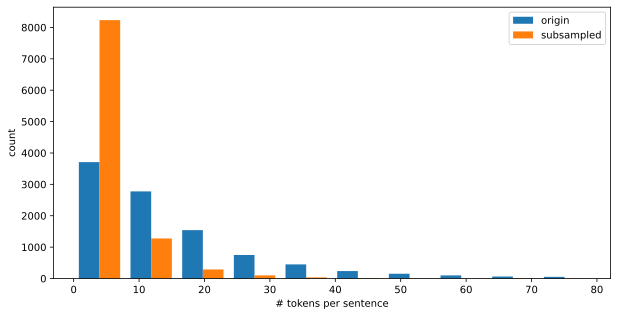

In [62]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline


def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    set_matplotlib_formats('svg')

def set_figsize(figsize=(10, 5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    

# plot
set_figsize((10, 5))
plt.hist([[len(line) for line in sentences if len(line) < 80],
          [len(line) for line in subsampled if len(line) < 80]])
plt.xlabel('# tokens per sentence')
plt.ylabel('count')
plt.legend(['origin', 'subsampled'])

In [63]:
def compare_counts(token):
    before = sum([line.count(token) for line in sentences])
    after = sum([line.count(token) for line in subsampled])
    return f"# of token {token}: before={before}, after={after}"

print(compare_counts(','))
print(compare_counts('sugar'))
print(compare_counts('salt'))
print(compare_counts('the'))
print(compare_counts('and'))

# of token ,: before=99, after=43
# of token sugar: before=314, after=83
# of token salt: before=439, after=79
# of token the: before=0, after=0
# of token and: before=5, after=0


### Getting the Corpus
We can map each token into an index to construct the corpus.

In [64]:
corpus = [vocab[line] for line in subsampled] 
corpus[0:3]

[[], [141, 1356], [275, 4]]

## Extracting Central Words and Context Words
We use words a distance from the central target word not exceeding the context window size as the context words of the given center target word.

We uniformly and randomly samples an integer to be used as the context window size between integer 1 and the `max_window_size` (maximum context window).

In [65]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a
        # "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

#### We set the maximum context window size to 5.

In [66]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)

In [67]:
print(f"center-context pairs: {len(all_centers)}")

center-context pairs: 44387


## Negative Sampling
We use negative sampling for approximate training. For a central and context word pair, we randomly sample $K$ noise words ($K = 5$ in here). According to the suggestion in the Word2vec paper, the noise word sampling probability $P(w)$ is the ratio of the word frequency of $w$ to the total word frequency raised to the power of $0.75$. 

In [68]:
# draw a candidate according to the sampling weights
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

In [69]:
def get_negatives(all_contexts, corpus, K):
    counter = count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

In [70]:
all_negatives = get_negatives(all_contexts, corpus, 5)

## Reading into Batches
We extract all central target words `all_centers`, and the context words `all_contexts` and noise words `all_negatives` of each central target word from the dataset. We will read them in random minibatches.

We're going to pad the sequences to account for different their lengths. Also, in order to aviod the effect of padding, we'll also mask those paddings.

In [71]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (np.array(centers).reshape(-1, 1), np.array(contexts_negatives),
            np.array(masks), np.array(labels))

In [72]:
x_1 = (1, [2, 2], [3, 3, 3, 3]) 
x_2 = (1, [2, 2, 2], [3, 3]) 
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = [[1]
 [1]]
contexts_negatives = [[2 2 3 3 3 3]
 [2 2 2 3 3 0]]
masks = [[1 1 1 1 1 1]
 [1 1 1 1 1 0]]
labels = [[1 1 0 0 0 0]
 [1 1 1 0 0 0]]


## DataLoader
Putting it altogether

In [73]:
from mxnet import autograd, context, gluon

def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

def dataloader(texts, batch_size, max_window_size, num_noise_words):
    num_workers = get_dataloader_workers()
    sentences = get_sentences(texts)
    vocab = Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)
    dataset = gluon.data.ArrayDataset(
        all_centers, all_contexts, all_negatives)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True,
                                      batchify_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [74]:
# print the first minibatch
data_iter, vocab = dataloader(texts, 512, 5, 5) 
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape) 
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


# Pretraining food2vec
We'll implement the **skip-gram model** by using embedding layers and minibatch multiplication.

In [75]:
from mxnet import autograd, gluon, np, npx 
from mxnet.gluon import nn
npx.set_np()

In [76]:
batch_size, max_window_size, num_noise_words = 128, 5, 5
data_iter, vocab = dataloader(texts, 128, 5, 5)

In [77]:
def take_second(elem):
    return elem[1]

sorted(vocab.token_freqs, reverse=True, key=take_second)

[('corn', 2194),
 ('less', 2166),
 ('wheat', 1866),
 ('artificial', 1512),
 ('contains', 1217),
 ('juice', 1080),
 ('organic', 1069),
 ('acid', 975),
 ('enriched', 883),
 ('fructose', 868),
 ('of', 847),
 ('oil', 780),
 ('flavor', 774),
 ('milk', 773),
 ('soy', 750),
 ('natural', 736),
 ('whole', 728),
 ('grain', 703),
 ('ingredients', 624),
 ('hydrogenated', 608),
 ('rice', 565),
 ('chocolate', 525),
 ('cane', 524),
 ('palm', 513),
 ('soybean', 476),
 ('flour', 473),
 ('acid,natural', 468),
 ('food', 466),
 ('vegetable', 453),
 ('andor', 451),
 ('per', 444),
 ('protein', 440),
 ('salt', 439),
 ('sodium', 400),
 ('following', 398),
 ('red', 379),
 ('b,vitamin', 370),
 ('added', 369),
 ('flavors', 360),
 ('contain', 347),
 ('syrup', 347),
 ('carbonated', 342),
 ('fat', 324),
 ('disodium', 320),
 ('yellow', 320),
 ('extract', 317),
 ('sugar', 314),
 (',yellow', 312),
 ('tea', 311),
 ('coffee', 309),
 ('lecithin', 307),
 ('acid,sodium', 301),
 ('white', 300),
 ('citric', 297),
 ('kernel',

### Embedding Layer

- `input_dim`: dictionary size
- `output_dim`: dimension of word vector

In [78]:
embed = nn.Embedding(input_dim=len(vocab), output_dim=100)
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(2014, 100), dtype=float32)

### Skip-gram
In forward calculation, the input of the skip-gram model contains the central target word index center and the concatenated context and noise word index `contexts_and_negatives`. In which, the center variable has the shape `(batch size, 1)`, while the `contexts_and_negatives` variable has the shape `(batch size, max_len)`. These two variables are first transformed from word indexes to word vectors by the word embedding layer, and then the output of shape `(batch size, 1, max_len)` is obtained by minibatch multiplication. Each element in the output is the inner product of the central target word vector and the context word vector or noise word vector.

In [79]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center) 
    u = embed_u(contexts_and_negatives) 
    pred = npx.batch_dot(v, u.swapaxes(1, 2)) 
    return pred

In [80]:
# Verify that the output shape should be (batch size, 1, max_len)
skip_gram(np.ones((2, 1)), np.ones((2, 4)), embed, embed).shape

(2, 1, 4)

## Training

In [81]:
# helper class to live plot model performance
from IPython import display

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(10, 5)):
        """Incrementally plot multiple lines."""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [82]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # Start the timer
        self.tik = time.time()

    def stop(self):
        # Stop the timer and record the time in a list
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        # Return the average time
        return sum(self.times) / len(self.times)

    def sum(self):
        # Return the sum of time
        return sum(self.times)

    def cumsum(self):
        # Return the accumulated times
        return np.array(self.times).cumsum().tolist()

In [83]:
class Accumulator:
    """Sum a list of numbers over time."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [84]:
import time

# loss function
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize model parameters
embed_size = 100 
net = nn.Sequential() 
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size), 
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

# in case GPU is available
def try_gpu(i=0):
    """
    Return gpu(i) if exists, otherwise return cpu().
    """
    return npx.gpu(i) if npx.num_gpus() >= i + 1 else npx.cpu()

# training
def train(net, data_iter, lr, num_epochs, ctx=try_gpu()):
    net.initialize(ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': lr})
    animator = Animator(xlabel='epoch', ylabel='loss',
                        xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # loss_sum, num_tokens
        for i, batch in enumerate(data_iter):
            center, context_negative, mask, label = [data.as_in_ctx(ctx) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                l = (loss(pred.reshape(label.shape), label, mask) / mask.sum(axis=1) * mask.shape[1])
            l.backward()
            trainer.step(batch_size)
            metric.add(l.sum(), l.size)
            if (i+1) % 50 == 0:
                animator.add(epoch+(i+1)/len(data_iter),
                             (metric[0]/metric[1],))
    print(f"loss {metric[0]/metric[1]}, {metric[1]/timer.stop()} tokens/sec on {ctx}")

**Now, we can train a skip-gram model using negative sampling.**

loss 0.24381665453726947, 5066.261923015424 tokens/sec on cpu(0)


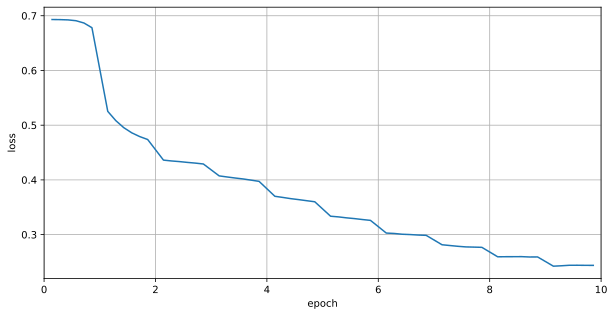

In [85]:
lr, num_epochs = 0.001, 10
train(net, data_iter, lr, num_epochs)

#### Save the embeddings

In [86]:
MODEL_VER = 'embeddings_v2.params'
MODEL_DIR = 'models'
net.save_parameters(os.path.join('..', MODEL_DIR, MODEL_VER))

In [ ]:
# loading the model parameters
# new_net = build_lenet(gluon.nn.Sequential())
# new_net.load_parameters(file_name, ctx=ctx)

## Get similar tokens

In [87]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    topk = npx.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]: # Remove the input words
        print(f"cosine sim={cos[i]}: {vocab.idx_to_token[i]}")

In [89]:
get_similar_tokens('milk', 5, net[0])

cosine sim=0.58542126: chocolate,
cosine sim=0.5662089: chocolate,peanut,corn
cosine sim=0.5608336: whites,artificial
cosine sim=0.5577182: flavor,milk
cosine sim=0.54592186: chocolate,sugar,cornstarch,less


In [90]:
net[0].weight.data().shape

(2014, 100)

#### Similar tokens with KNN and pretrained Glove

In [439]:
# loading pretrained GloVe
from mxnet import np, npx 
from mxnet.contrib import text 
npx.set_np()

text.embedding.get_pretrained_file_names().keys()

dict_keys(['glove', 'fasttext'])

In [440]:
print(text.embedding.get_pretrained_file_names('glove'))

['glove.42B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.840B.300d.txt', 'glove.twitter.27B.25d.txt', 'glove.twitter.27B.50d.txt', 'glove.twitter.27B.100d.txt', 'glove.twitter.27B.200d.txt']


In [441]:
glove_6b50d = text.embedding.create('glove', pretrained_file_name='glove.6B.50d.txt')

In [442]:
len(glove_6b50d)

400001

In [443]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [436]:
def knn(W, x, k):
    # The added 1e-9 is for numerical stability
    cos = np.dot(W, x.reshape(-1,)) / (
        np.sqrt(np.sum(W * W, axis=1) + 1e-9) * np.sqrt((x * x).sum()))
    topk = npx.topk(cos, k=k, ret_typ='indices')
    return topk, [cos[int(i)] for i in topk]

In [445]:
def get_similar_tokens_knn(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec,
                    embed.get_vecs_by_tokens([query_token]), k+1)
    for i, c in zip(topk[1:], cos[1:]): # Remove input words
        print(f"cosine sim={c}: {embed.idx_to_token[int(i)]}")

In [446]:
get_similar_tokens_knn('egg', 5, glove_6b50d)

cosine sim=0.90045774: eggs
cosine sim=0.76799345: butter
cosine sim=0.7664296: milk
cosine sim=0.7564414: cake
cosine sim=0.7515441: yolk


***
***

# Food Classifier
We'll use the pretrained ingredients vectors (from above) to predict the food name.

### preparing data

In [91]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
recipes = recipes.loc[recipes["category"].notnull(),]

In [159]:
set(recipes["category"].values)

{'7ELEVEN',
 'BREAD',
 'CANDY',
 'CEREAL',
 'COOKIE',
 'CRACKERS',
 'DAIRY',
 'DELI',
 'DESSERT',
 'FRZNBAKE',
 'FRZNBRK',
 'FRZNFISH',
 'FRZNMEAL',
 'FRZNPZZA',
 'FRZNSNK',
 'FRZNVEG',
 'ICECREAM',
 'JUICE',
 'MARSSNCK',
 'MEXICAN',
 'PICKLES',
 'PRODUCE',
 'SNACKS',
 'SNKCAKE',
 'SOUP'}

In [92]:
labels = list(recipes["category"].values)
texts_raw_711 = list(recipes["ingredients"].values)

In [157]:
labels

array([23, 14, 23, 23, 23, 23, 12, 23,  1, 23, 23,  1,  1, 23, 23,  1,  4,
       23,  1, 12, 14, 23, 23, 23, 23, 13,  7, 23, 23, 19, 19, 23,  1,  0,
        1,  7, 23, 23,  1, 18, 23,  1, 12, 23, 23,  1, 13, 23, 23, 23, 23,
       23, 23,  1, 23, 23, 23, 12, 23, 23, 12,  1,  1, 12,  1, 23, 23,  1,
        1, 23, 10, 23,  1, 23, 19,  7,  1, 23, 12, 23, 23, 23,  1, 23, 23,
        1,  1, 23, 23, 23, 23, 23,  9,  7, 23,  1, 23,  1, 23, 23,  1, 23,
       23, 23, 23, 23, 23,  1, 12, 23, 23,  1, 12,  7, 17, 23,  4,  1, 12,
        1, 15, 23,  1, 23, 23,  1, 10, 14, 12, 23, 19,  7, 24, 23,  1, 23,
       23, 20, 12, 13, 23, 23, 21, 12, 23, 21, 23,  6, 12,  7, 23,  1, 12,
        1, 23, 23, 23, 12,  5,  4, 21,  1,  1, 23,  1,  1, 19, 13,  1, 15,
        7, 13, 23, 23, 21, 13, 23,  1, 10,  7, 23, 23, 23, 23,  1, 23, 21,
        0, 23, 23,  7,  8, 22,  1,  0, 23, 19, 23,  7,  3, 23,  1, 15, 12,
        5,  6, 23, 23, 23,  1, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23,  7, 23,  1, 23

In [93]:
texts_711, vocab_711 = ingredient_cleanup(texts_raw_711)

In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

In [96]:
print(f"texts size: {len(texts_711)}, labels size: {len(labels)}")

texts size: 898, labels size: 898


In [97]:
def tokenize(lines, token='word'):
    """Split sentences into word or char tokens."""
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type '+token)

In [98]:
train_tokens = tokenize(texts_711, token='word')

In [99]:
sentences = get_sentences(texts_711)

In [100]:
train_vocab = Vocab(train_tokens, min_freq=5)

In [101]:
len(train_vocab)

809

In [102]:
train_vocab.token_freqs

[('', 1104),
 ('corn', 652),
 ('wheat', 561),
 ('less', 534),
 ('artificial', 390),
 ('enriched', 371),
 ('acid', 366),
 ('following', 331),
 ('fructose', 323),
 ('bleached', 235),
 ('stearoyl', 231),
 ('propionate', 149),
 ('sorbate', 141),
 ('flour,riboflavin,folic', 131),
 ('soybean', 126),
 ('of', 123),
 ('soy', 123),
 ('sodium', 116),
 ('syrup', 111),
 ('potassium', 110),
 ('unbleached', 110),
 ('protein', 97),
 ('oil', 95),
 ('aluminum', 90),
 ('sorbic', 89),
 ('cheese', 88),
 ('flour', 84),
 ('hydrogenated', 84),
 ('fatty', 82),
 ('glycol', 82),
 ('palm', 80),
 ('oil,contains', 78),
 ('food', 77),
 ('dry', 75),
 ('lecithin', 73),
 ('sugar,enriched', 73),
 ('vegetable', 70),
 ('bean', 63),
 ('added', 61),
 ('yellow', 61),
 ('contains', 60),
 ('flour,vegetable', 60),
 ('milk', 60),
 ('whole', 60),
 ('flavor', 59),
 ('juice', 59),
 ('gum,sodium', 57),
 ('modified', 57),
 ('color', 56),
 ('mozzarella', 55),
 ('barley', 54),
 ('kernel', 54),
 ('turmeric', 54),
 ('citric', 51),
 ('per

(array([812.,  82.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <a list of 19 Patch objects>)

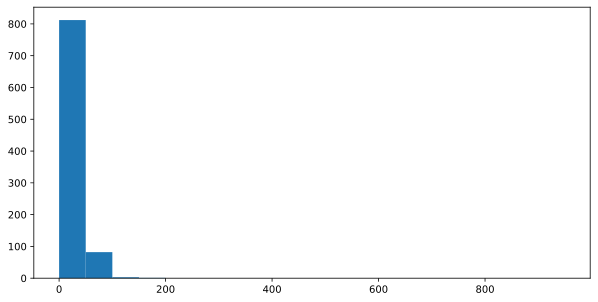

In [103]:
set_figsize((10, 5))
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [104]:
# padding to the same length
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Trim
    return line + [padding_token] * (num_steps - len(line))  # Pad

num_steps = 20 # sequence length
train_features = np.array([truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
train_features.shape

(898, 20)

### Creating data iterator

In [105]:
from mxnet import gluon

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [106]:
train_iter = load_array((train_features, labels), 64)

In [107]:
for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break

X (64, 20) y (64,)


In [108]:
train_valid_split = 0.8
training_samples = int(train_features.shape[0] * train_valid_split)
validation_samples = int(train_features.shape[0] * (1 - train_valid_split))

X_train = train_features[:training_samples]
y_train = labels[:training_samples]
X_test = train_features[training_samples: training_samples + validation_samples]
y_test = labels[training_samples: training_samples + validation_samples]

In [109]:
train_iter = load_array((X_train, y_train), 64)
test_iter = load_array((X_test, y_test), 64)

### RNN-based classification model

In [110]:
from mxnet import gluon, init, np, npx 
from mxnet.gluon import nn, rnn 
from mxnet.contrib import text 
npx.set_np()

batch_size = 64

In [121]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    ctxes = [npx.gpu(i) for i in range(npx.num_gpus())]
    return ctxes if ctxes else [npx.cpu()]

In [112]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, num_classes,**kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(num_classes)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [124]:
class SimpleDense(nn.Block):
    def __init__(self, vocab_size, embed_size, num_classes,**kwargs):
        super(SimpleDense, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.Dense(16, activation="relu")
        self.decoder = nn.Dense(num_classes, activation="softmax")

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [125]:
# embed_size, num_hiddens, num_layers, ctx, num_classes = 100, 100, 2, try_all_gpus(), max(labels)+1
# net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers, num_classes)
# net.initialize(init.Xavier(), ctx=ctx)

In [148]:
vocab_size = len(vocab)
embed_size = 100
num_classes = len(set(labels))
net = SimpleDense(vocab_size, embed_size, num_classes)
net.initialize(init.Xavier(), ctx=ctx)

In [149]:
from mxnet.gluon import nn

def try_gpu(i=0):
    """
    Return gpu(i) if exists, otherwise return cpu().
    """
    return npx.gpu(i) if npx.num_gpus() >= i + 1 else npx.cpu()

ctx = try_all_gpus()

embed_size = 100 
net_pred = nn.Sequential() 
net_pred.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size), 
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

MODEL_VER = 'embeddings_v2.params'
MODEL_DIR = 'models'
net_pred.load_parameters(os.path.join('..', MODEL_DIR, MODEL_VER))

embeds = net_pred[0].weight.data()
print(embeds.shape)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

(2014, 100)


In [151]:
# using GloVe pretrained vectors
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
print(embeds.shape)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

(2014, 100)


In [152]:
def split_batch(X, y, ctx_list):
    """Split X and y into multiple devices specified by ctx."""
    assert X.shape[0] == y.shape[0]
    return (gluon.utils.split_and_load(X, ctx_list),
            gluon.utils.split_and_load(y, ctx_list))

In [153]:
def train_batch(net, features, labels, loss, trainer, ctx_list,
                     split_f=split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The True flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(accuracy(pred_shard, y_shard)
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [154]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis=1).astype('float32') == y.astype(
            'float32')).sum())
    else:
        return float((y_hat.astype('int32') == y.astype('int32')).sum())

def evaluate_accuracy_gpus(net, data_iter, split_f=split_batch):
    # Query the list of devices
    ctx = list(net.collect_params().values())[0].list_ctx()
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for features, labels in data_iter:
        X_shards, y_shards = split_f(features, labels, ctx)
        # Run in parallel
        pred_shards = [net(X_shard) for X_shard in X_shards]
        metric.add(sum(float(accuracy(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)), labels.size)
    return metric[0] / metric[1]

In [155]:
def train_classifier(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=try_all_gpus(), split_f=split_batch):
    num_batches, timer = len(train_iter), Timer()
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        metric[0] / metric[2], metric[1] / metric[3], test_acc))
    print('%.1f examples/sec on %s' % (
        metric[2] * num_epochs / timer.sum(), ctx_list))

In [ ]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_classifier(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

In [592]:
def predict_food(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()], ctx=try_gpu())
    label = np.argmax(net(sentence.reshape(1, -1)), axis=1)
    return label, le.inverse_transform([int(label[0])])

In [597]:
predict_food(net, vocab, 'Cake')

(array([458.]), array(['Bread'], dtype='<U84'))

***
***

## Food Classifier: Dense layer only

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

sys.path.insert(0, '.')
sys.path.insert(0, '..')

import re
import numpy as np
import pandas as pd
import collections
import random
import math
import matplotlib.pyplot as plt

from mxnet import autograd, context, gluon
from mxnet import autograd, gluon, np, npx 
from mxnet.gluon import nn
npx.set_np()

In [36]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
recipes = recipes.loc[recipes["category"].notnull(),]

labels = list(recipes["category"].values)
texts_ = list(recipes["ingredients"].values)

# removing numbers
texts = []
for text in texts_:
    texts.append(re.sub('[^a-zA-Z ,]+', '', text))
    
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

In [57]:
from mxnet.gluon import nn

def try_gpu(i=0):
    """
    Return gpu(i) if exists, otherwise return cpu().
    """
    return npx.gpu(i) if npx.num_gpus() >= i + 1 else npx.cpu()

ctx = try_gpu()

embed_size = 100 
net_pred = nn.Sequential() 
net_pred.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size), 
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

MODEL_VER = 'embeddings_v1.params'
MODEL_DIR = 'models'
net_pred.load_parameters(os.path.join('..', MODEL_DIR, MODEL_VER))

embedding_matrix = net_pred[0].weight.data()

In [63]:
maxlen = 20
max_words = 1000
num_classes = int(max(labels) + 1)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(len(vocab), embed_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(num_classes, 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           289100    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                50025     
Total params: 339,125
Trainable params: 339,125
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
tokenizer = Tokenizer(num_words=max_words)

In [41]:
tokenizer.fit_on_texts(texts)

In [42]:
sequences = tokenizer.texts_to_sequences(texts)

In [44]:
len(sequences)

898

In [45]:
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

Found 1310 unique tokens


In [46]:
tokenizer.document_count

898

In [47]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.array(labels)
print(f"data size: {data.shape}")
print(f"labels size: {labels.shape}")

data size: (898, 20)
labels size: (898,)


In [48]:
train_valid_split = 0.8
training_samples = int(data.shape[0] * train_valid_split)
validation_samples = int(data.shape[0] * (1 - train_valid_split))

In [49]:
# splitting and shuffling the data
# indices = np.arange(data.shape[0]).astype(int)
# indices = np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]

X_train = np.array(data[:training_samples])
y_train = np.array(labels[:training_samples])
X_valid = np.array(data[training_samples: training_samples + validation_samples])
y_valid = np.array(labels[training_samples: training_samples + validation_samples])

In [50]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")

X_train shape: (718, 20), y_train shape: (718,)
X_valid shape: (179, 20), y_valid shape: (179,)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))

Train on 718 samples, validate on 179 samples
Epoch 1/10


# Training

## Version 1

Training word embedding from scratch.

**NOTE:** This setup does not account for context (recipe) of words (ingredients)

In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy

In [197]:
vocab_count = len(tokenizer.index_word)
embedding_dim = 1000
num_classes = max(labels) + 1

In [198]:
model = Sequential()
model.add(Embedding(vocab_count, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(32))
# model.add(GlobalAveragePooling1D())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 1000)          7788000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                33056     
_________________________________________________________________
dense_11 (Dense)             (None, 9887)              326271    
Total params: 8,147,327
Trainable params: 8,147,327
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_valid, y_valid))

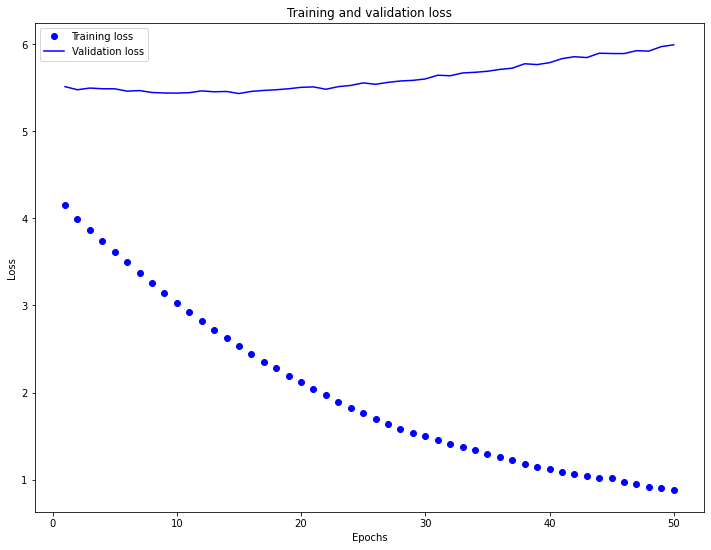

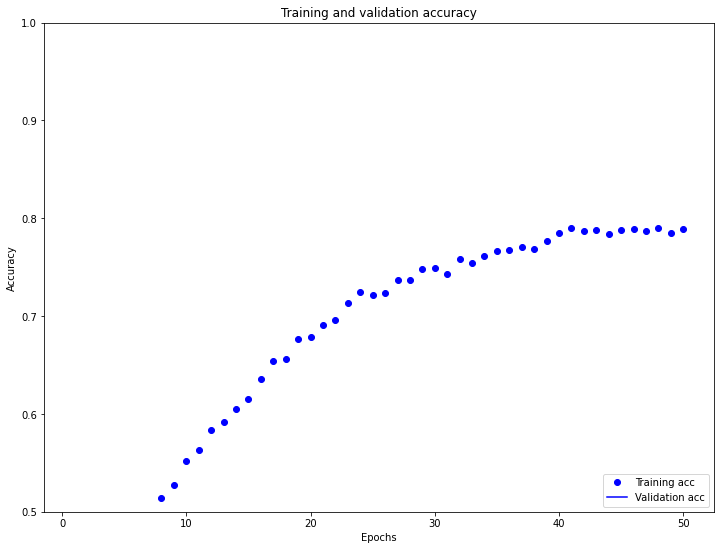

In [123]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()